In [1]:
%matplotlib inline


==========================================================
Load CT slices and plot axial, sagittal and coronal images
==========================================================

This example illustrates loading multiple files, sorting them by slice
location, building a 3D image and reslicing it in different planes.

.. usage:

   reslice.py <glob>
   where <glob> refers to a set of DICOM image files.

   Example: python reslice.py "*.dcm". The quotes are needed to protect
   the glob from your system and leave it for the script.

.. note:

   Uses numpy and matplotlib.

   Tested using series 2 from here
   http://www.pcir.org/researchers/54879843_20060101.html


785


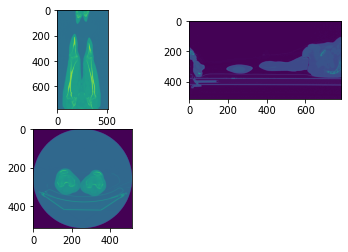

In [2]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob

# load the DICOM files
import os
PathDicom = "/data/Pat1/CT_scan/DICOM/PA000001/ST000001/SE000005"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".zip" not in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))
# print(len(lstFilesDCM))
files = []
# print('glob: {}'.format(sys.argv[1]))
for fname in lstFilesDCM:
#     print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))

# print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

# print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)
print(len(slices))

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 3)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 1)
plt.imshow(img3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)

plt.show()

In [3]:
# np.average(img3d.ravel())

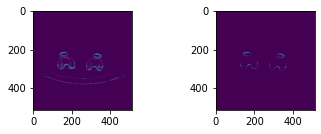

In [24]:
import copy
# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 1)
my_array = copy.deepcopy(img3d[:, :, img_shape[2]//2])
my_array[my_array <= 1500] = 0
plt.imshow(my_array)

a1.set_aspect(ax_aspect)
a2 = plt.subplot(2, 2, 2)
my_array = copy.deepcopy(img3d[:, :, img_shape[2]//2])
my_array[my_array <= 2000] = 0
plt.imshow(my_array)

a2.set_aspect(ax_aspect)


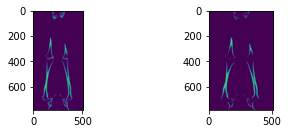

In [25]:
a3 = plt.subplot(2, 2, 1)
my_array = copy.deepcopy(img3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)
my_array[my_array <= 1500] = 0
plt.imshow(my_array)
a3.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
my_array = copy.deepcopy(img3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)
my_array[my_array <= 2000] = 0
plt.imshow(my_array)
a2.set_aspect(ax_aspect)


In [34]:
array_3d = copy.deepcopy(img3d)
array_3d[array_3d <= 1500] = 0


In [19]:
x, y, z = [], [], []

for i, img2d in enumerate(img3d):
    for j, img1d in enumerate(img2d):
        for k, pixal in enumerate(img1d):
            if pixal > 1500:
                x.append(int(i))
                y.append(int(j))
                z.append(int(k))

x = np.array(x)
y = np.array(y)
z = np.array(z)

In [20]:
import ipyvolume as ipv
ipv.figure()
ipv.scatter(x, y, z, marker='sphere')

ipv.save('bone.html')


In [41]:
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def plot_3d(image):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the   
    # camera
    p = image  # .transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes_lewiner(p)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of    
    # triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()

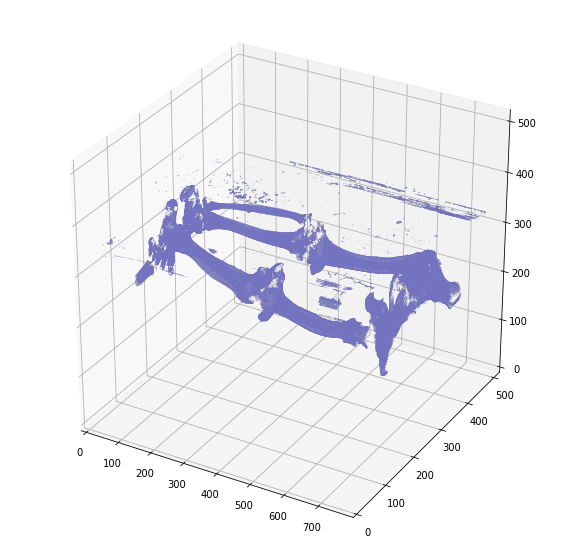

In [39]:
plot_3d(array_3d)

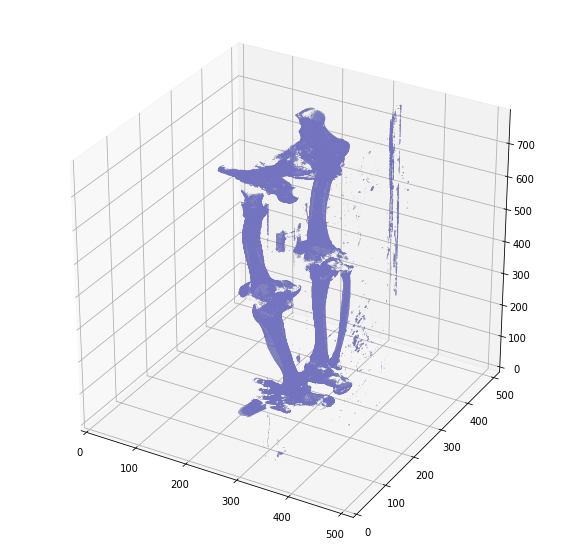

In [42]:
plot_3d(array_3d)